In [1]:
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import ot
import ot.plot

from matplotlib import pyplot as plt

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [2]:
adata_mvi = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")

In [3]:
HALOVI.setup_anndata(adata_mvi, time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)    

self.w_a :1
yes there is aligner


In [4]:
model = model.load("model_hair_align_causal01_20",adata_mvi)

INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
self.w_a :1
yes there is aligner


In [6]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


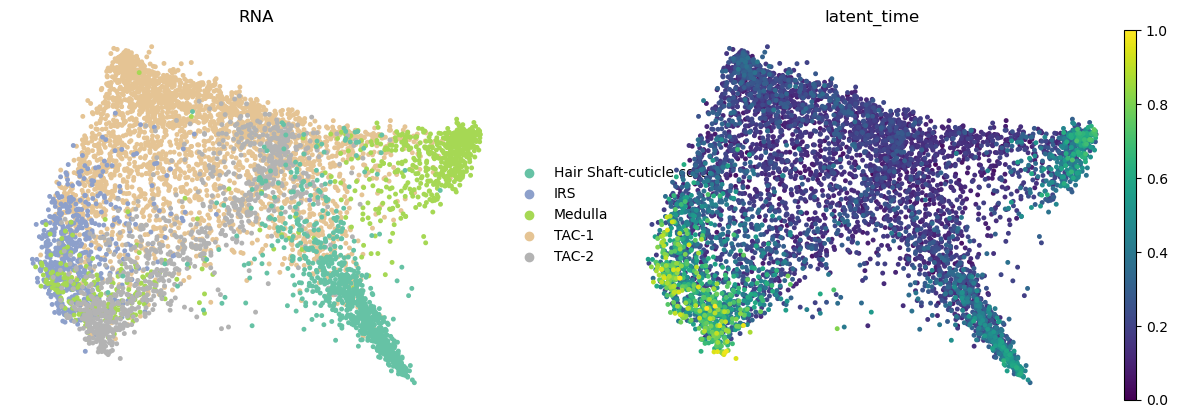

In [7]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.01, negative_sample_rate=0.05, spread=10)
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=['celltype', "latent_time"], title="RNA",palette="Set2")
adata_mvi.obsm["umap_all"] = adata_mvi.obsm["X_umap"] 

In [6]:
for i in range(20):
    adata_mvi.obs["epxr_latent_"+str(i)] = latent_expr[:,i]

for i in range(20):
    adata_mvi.obs["atac_latent_"+str(i)] =  latent_acc[:,i]

In [9]:
adata_mvi.obsm["latent"] = np.concatenate([latent_acc , latent_expr],axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.01, negative_sample_rate=0.05, spread=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [12]:
## read paire data
# adata_pair = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
# rna_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired3.h5ad")
rna_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired4.h5ad")
rna_pair.obs = rna_pair.obs.set_index("atac.bc")
from complementary_models import split_rna
adata_pair = split_rna(adata_mvi)
adata_pair.obsm["X_umap"] = adata_mvi.obsm["X_umap"]
adata_pair.layers["peaks"] = rna_pair.layers["peaks"]
adata_pair.var.index =  adata_pair.var.index.map(str.upper)
adata_pair.layers["norm"] = model.get_normalized_expression()
# adata_pair.layers["norm"] =rna_pair.layers["norm"]

In [24]:
adata_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired.h5ad")
adata_pair.obsm["X_umap"] = adata_mvi.obsm["X_umap"]


In [55]:
adata_pair.layers["norm"] = model.get_normalized_expression()

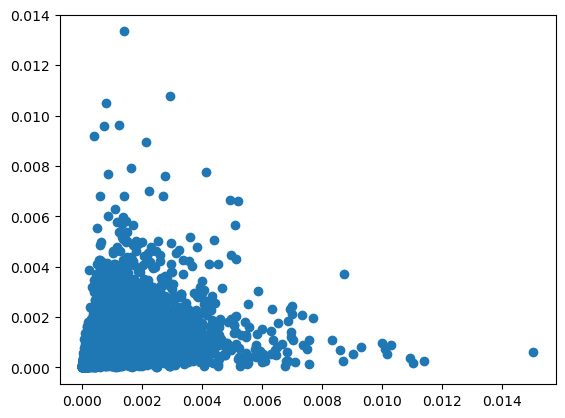

In [102]:
plt.scatter(adata_pair.layers["norm"][:, 801], adata_pair.layers["norm"][:, 800])

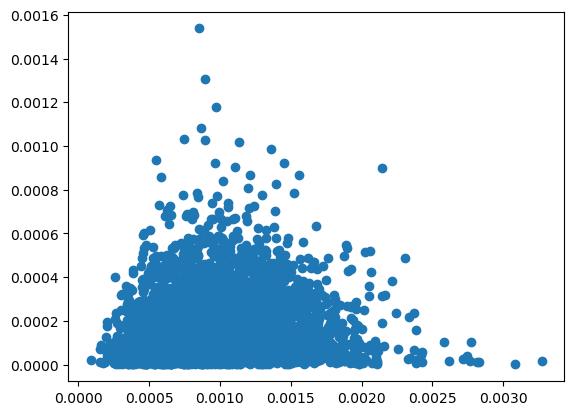

In [37]:
plt.scatter(adata_pair.layers["norm"][:, 7], adata_pair.layers["norm"][:, 810])

In [16]:
def plot_gene_peaks(adata, genename, library_size_atac=1e3, library_size_rna = 1e13, save_RNA=None,  save_Peak=None, vmin=None, vmax=None):
    index_gene = np.where(adata.var.index==genename)[0]
    peaks = adata.layers["peaks"][:, index_gene]
    adata.obs["peak"] = peaks.toarray()*library_size_atac
    adata.obs["gene"] = adata.layers["norm"][:, index_gene] * library_size_rna
    # adata.obs["gene"] = adata.X[:, index_gene].toarray() * library_size_rna


    if save_Peak!=None and save_RNA!=None: 
        with plt.rc_context():
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["gene"], color_map = 'coolwarm', vmin=vmin, vmax=vmax, show=False)
            plt.savefig(save_RNA, dpi=300)
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peak"], color_map = 'coolwarm', vmin=vmin, vmax=vmax, show=False)
            plt.savefig(save_Peak, dpi=300)
    else:
        sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["gene"], color_map = 'coolwarm', vmin=vmin, vmax=vmax)
        # sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peak"], color_map = 'coolwarm', vmin=vmin, vmax=vmax)



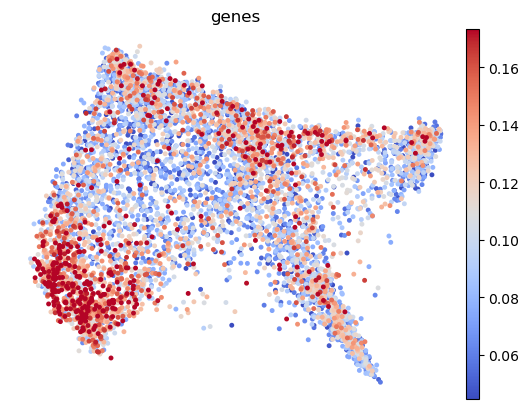

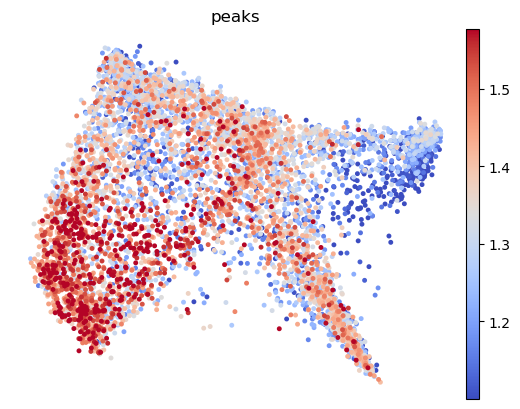

In [212]:
plot_gene_peaks(adata_pair, "DLX3", vmin="p05", vmax="p95", save_Peak="hair_gene_peak/umap_pair/DLX3_peaks.png",  save_RNA="hair_gene_peak/umap_pair/DLX3_RNA.png")

In [14]:
from causallearn.utils.cit import CIT

T = adata_mvi.obs['latent_time'].to_numpy()
T = np.expand_dims(T, axis=1)
print(T.shape)



X = latent_atac_indep
Y = latent_expr_indep
print(X.shape)
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)


KCI_data = np.concatenate([X, Y_Residual, T], -1)
X_index = range(X.shape[1])
E_index = range(X.shape[1],X.shape[1]+Y_Residual.shape[1])
T_index = range(X.shape[1]+Y_Residual.shape[1],X.shape[1]+Y_Residual.shape[1]+1)
kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
pValue = kci_obj(X_index, E_index, T_index)
print("decoupled pvalue: {}".format(pValue))

(6436, 1)
(6436, 10)
decoupled pvalue: 0.0


In [83]:
adata_pair.obs = adata_pair.obs.set_index("atac.bc")
adata_mvi.obs["cell_subtypes"] = adata_pair.obs["cell_sub_types"]

In [85]:
adata_multi_ini  = adata_mvi[adata_mvi.obs['cell_subtypes'].isin( ['TAC-HS', 'TAC-IRS'])].copy()
adata_multi_end = adata_mvi[adata_mvi.obs['cell_subtypes'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()

In [88]:

Xi = adata_multi_ini.obs[[
    # 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
    #                           'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
    #                           'atac_latent_8', 'atac_latent_9', 
                              'atac_latent_10', 'atac_latent_11', 
                              'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
                              'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')

# Yi = adata_multi_ini.obs['celltype'].tolist()
Yi = adata_multi_ini.obs['cell_subtypes'].tolist()


umap_i = adata_multi_ini.obsm['X_umap']


Xf = adata_multi_end.obs[[
    # 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
    #                           'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
    #                           'atac_latent_8', 'atac_latent_9', 
                              'atac_latent_10', 'atac_latent_11', 
                              'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15',
                              'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')

Yf = adata_multi_end.obs['cell_subtypes'].tolist()

umap_f = adata_multi_end.obsm['X_umap']

In [11]:
adata_multi_end.obs.celltype.unique()

['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex']
Categories (3, object): ['Hair Shaft-cuticle.cortex', 'IRS', 'Medulla']

In [61]:
adata_multi_end.obs["cell_subtypes"]

Series([], Name: cell_subtypes, dtype: category
Categories (0, object): [])

In [58]:
n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac1

0

In [90]:
n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs.loc[adata_multi_ini.obs.celltype=="TAC-1", "prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


# a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2  # uniform distribution on samples

M = ot.dist(Xi, Xf,metric = 'sqeuclidean')

/tmp/ipykernel_8551/898157017.py:8: RuntimeWarning: invalid value encountered in long_scalars
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:9: RuntimeWarning: invalid value encountered in long_scalars
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [96]:
lambd = 0.1
# lambd = 4e-1

Gs = ot.sinkhorn(a, b, M, lambd)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 191
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


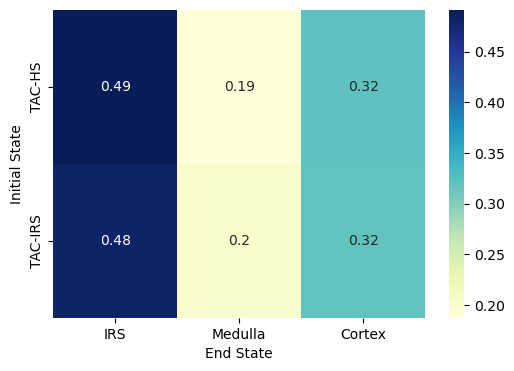

<Figure size 640x480 with 0 Axes>

In [97]:
import seaborn as sns
prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-HS', 'TAC-IRS']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.show()
plt.savefig("figs/Hair/20_aligned/OT.pdf", dpi=300)

In [128]:
def plot2D_samples_mat(xs, xt, G, thr=1e-8,color =[.5, .5, 1] ):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
    b : ndarray, shape (nt,2)
        Target samples positions
    G : ndarray, shape (na,nb)
        OT matrix
    thr : float, optional
        threshold above which the line is drawn
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

#     if ('color' not in kwargs) and ('c' not in kwargs):
#         kwargs['color'] = 'k'
    mx = G.max()
#     if 'alpha' in kwargs:
#         scale = kwargs['alpha']
#         del kwargs['alpha']
#     else:
#         scale = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=0.05,c = color)
                plt.arrow(xs[i, 0], xt[j, 0], xs[i, 1]-xs[i, 0], xt[j, 1]-xt[j, 0],
                        alpha=0.01)        

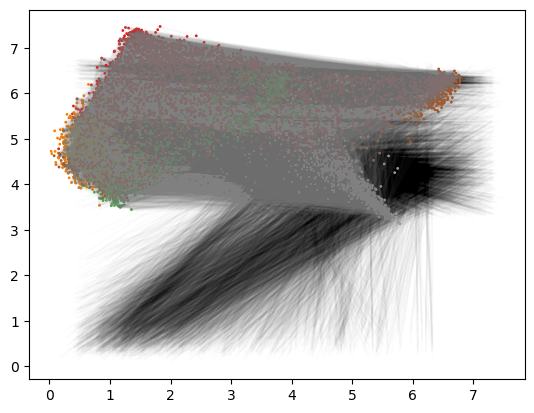

In [129]:
color_set =  {'TAC-1' : '#e41a1c', 'TAC-2' : '#4daf4a', 'IRS':'#ff7f00','Medulla' : '#a65628','Hair Shaft-cuticle.cortex':'#999999'}


plt.figure(8)
plot2D_samples_mat(umap_i, umap_f, Gs, 
                           color='grey', thr=np.percentile(Gs,99.999))
plt.scatter(umap_i[:,0], umap_i[:,1], c=[color_set[x] for x in Yi],s=1)
plt.scatter(umap_f[:,0], umap_f[:,1], c=[color_set[x] for x in Yf],s=1)
plt.show()
